# Quora Question Pairs

**1. Business Problem**

**1.1 Description**

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

> Credits: Kaggle

__ Problem Statement __

* Identify which questions asked on Quora are duplicates of questions that have already been asked.
* This could be useful to instantly provide answers to questions that have already been answered.
* We are tasked with predicting whether a pair of questions are duplicates or not.

**1.2 Sources/Useful Links**

Source : https://www.kaggle.com/c/quora-question-pairs

__ Useful Links __
Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

**1.3 Real world/Business Objectives and Constraints**

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

**2. Machine Learning Problem**

**2.1 Data**

**2.1.1 Data Overview**

- Data will be in a file Train.csv
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
- Size of Train.csv - 60MB
- Number of rows in Train.csv = 404,290

**2.1.2 Example Data point**

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

**2.2 Mapping the real world problem to an ML problem**

**2.2.1 Type of Machine Leaning Problem**

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

**2.2.2 Performance Metric**

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s):

log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
Binary Confusion Matrix

**2.3 Train and Test Construction**

We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

--> If we had time stamp in the data then we would have taken time based splitting (70:30 where old questions (70%) = training dataset and (30%) = test dataset). Because the types of questions change through time. The topic which is popular today might not be tomorrow. 

**3. Exploratory Data Analysis**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**3.1 Reading data and basic stats**

In [2]:
df = pd.read_csv("train.csv")
print(f"Number of data points or row: {df.shape[0]}, Number of columns: {df.shape[1]}")

Number of data points or row: 404290, Number of columns: 6


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


To check if there are any empty cell. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

* id: Looks like a simple rowID
* qid{1, 2}: The unique ID of each question in the pair
* question{1, 2}: The actual textual contents of the questions.
* is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

We can see here that "question2" column has 2 "Null" cells and "question1" has 1 "Null" cell. --> We will deal with it later. 

**3.2.1 Distribution of data points among output classes**
- Number of duplicate (similar) and non-duplicate (non-similar) questions. (To check is it balanced or imbalanced dataset) --> We can plot pie chart or the bar plot will also work. 

Percentage of duplicate in training data: 36.92%
Percentage of non-duplicate in training data: 63.08%


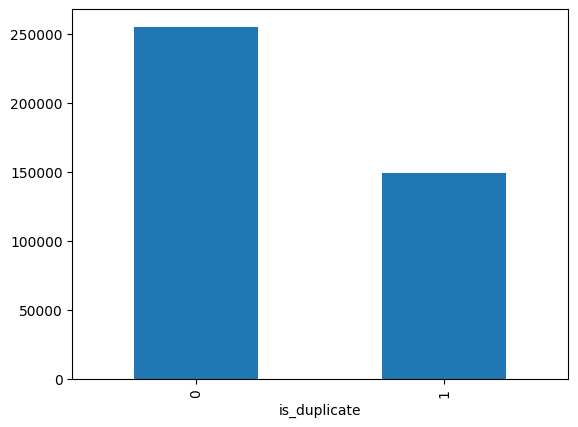

In [5]:
#df.groupby('is_duplicate')['id'].count().plot(kind='pie')
df.groupby('is_duplicate')['id'].count().plot(kind='bar')
print(f"Percentage of duplicate in training data: {df['is_duplicate'].mean()*100:.2f}%")
print(f"Percentage of non-duplicate in training data: {100 - df['is_duplicate'].mean()*100:.2f}%")

**3.2.2 Number of unique questions**

* Here instead of pair I want to see how many unique questions are there. 

In [6]:
ques = pd.Series(df["qid1"].tolist() + df["qid2"].tolist())          # Converting all questions into one list.
uni_ques = len(np.unique(ques))
print(f"Unique questions: {uni_ques}")

# How many questions repeated more than one time in the pair?
ques_morethan_one = np.sum(ques.value_counts() > 1)
print(f"Questions repeated more than once: {ques_morethan_one} ({(ques_morethan_one/uni_ques) * 100:.2f}%)")

# Max times a question has repeated. 
ques_max = np.max(ques.value_counts())
print(f"A Question repeated maximum: {ques_max} times")

Unique questions: 537933
Questions repeated more than once: 111780 (20.78%)
A Question repeated maximum: 157 times


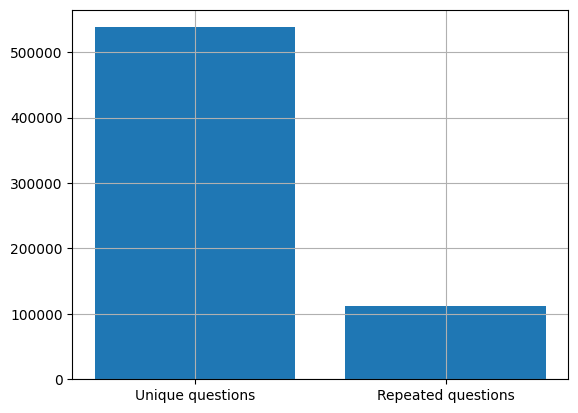

In [7]:
var1 = ["Unique questions", "Repeated questions"]
var2 = [uni_ques, ques_morethan_one]

plt.bar(var1, var2, align='center')
plt.grid()
plt.show()

**3.2.3 Checking for Duplicates** 

* Now, I want to see if there is any duplicate pairs of questions present in the data. 

In [29]:
pair_duplicate = df[["qid1", "qid2", "is_duplicate"]].groupby(["qid1", "qid2"]).count().reset_index()

print(f"Number of duplicate questions pair: {pair_duplicate.shape[0] - df.shape[0]}")

Number of duplicate questions pair: 0


**3.2.4 Number of occurrences of each question**

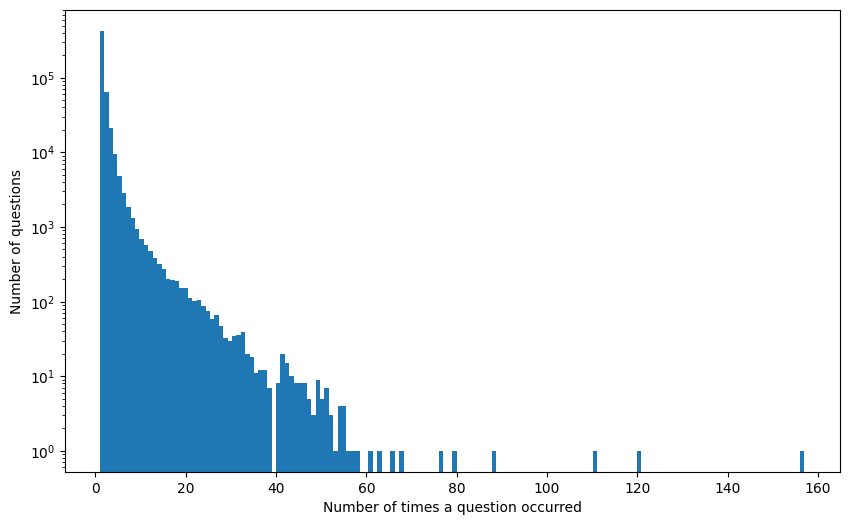

In [40]:
plt.figure(figsize= (10,6))
plt.hist(ques.value_counts(), bins=160)
plt.yscale('log')
plt.xlabel("Number of times a question occurred")
plt.ylabel("Number of questions")
plt.show()

**3.2.5 Checking for NULL values**

In [51]:
nan_row = df[df.isnull().any(axis=1)]
print(nan_row)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [52]:
# Filling the null value with the empty string " ".

df = df.fillna('')
nan_row = df[df.isnull().any(axis = 1)]
print(nan_row)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


**3.3 Basic Feature Extraction (before cleaning)**